# Project Goal:

####  Go over the main factors that might affect individual's insurance cost and build and test various regression models that predicts individual’s insurance cost.

### Dataset Exploration:

1. age - age of primary beneficiary
2. sex - insurance contractor genter (female / male)
3. bmi - body mass index, ratio of height to weight (ideally 18.5 to 24.9)
4. children - number of children covered by health insurance (number of dependents)
5. smoker - smoking status
6. region - beneficiary's residential area in U.S (Northeast, Southeast, Northwest, Southwest)

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

In [346]:
df = pd.read_csv('insurance.csv')

In [347]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [348]:
df.shape

(1338, 7)

In [349]:
# charges is our target variable in this project

df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [350]:
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [351]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


## Distribution of Charges (Target Variable) and see if transformation is needed

Text(0.5, 1.0, 'Distribution of charges')

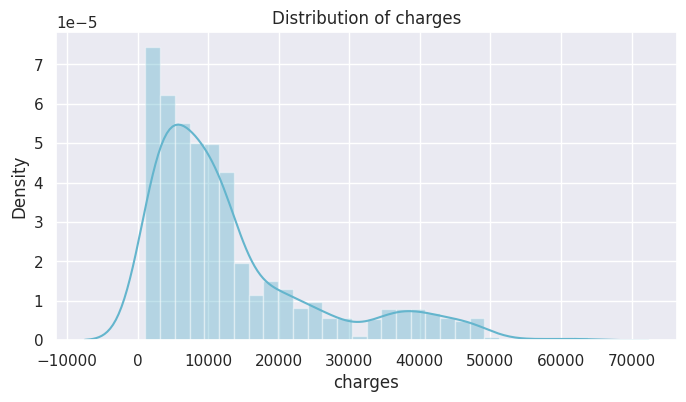

In [352]:
# Here, we found that the target variable (charges) are right-skewed

sns.set(style='darkgrid')

f, ax = plt.subplots(1,1, figsize=(8,4))
ax = sns.distplot(df['charges'], kde=True, color='c')
plt.title("Distribution of charges")

Text(0.5, 1.0, 'Distribution of charges')

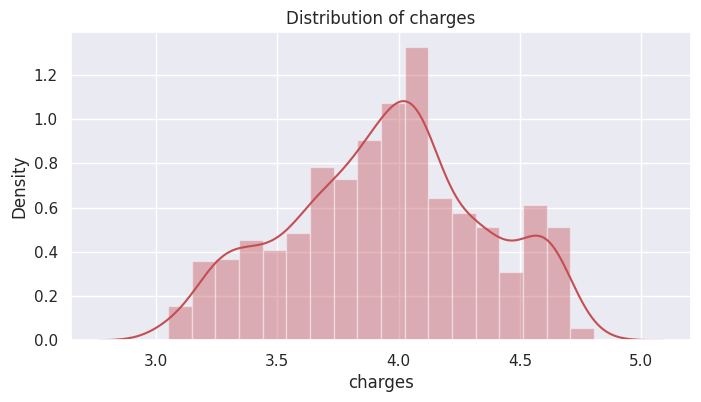

In [353]:
# Lets see how log-transformation on target features change distribution

f, ax = plt.subplots(1,1, figsize=(8,4))
ax = sns.distplot(np.log10(df['charges']), kde=True, color='r')
plt.title("Distribution of charges")

## Charges by Region

In [354]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [355]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending=False)

In [356]:
charges = charges.reset_index()

In [357]:
charges

,region,charges
0,southeast,5.363690e+06
1,northeast,4.343669e+06
2,northwest,4.035712e+06
3,southwest,4.012755e+06


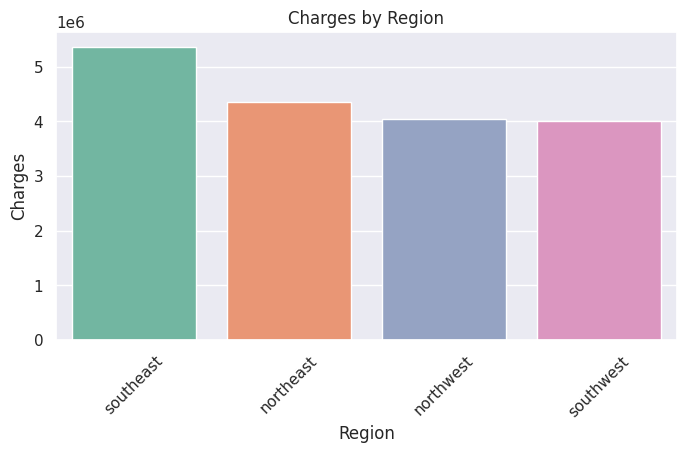

In [358]:
# Southeast regions (Georgia, Florida) seem to have the highest insurance charges compared to Southwest regions (Arizona, Nevada)

f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(x='region', y='charges', data=charges, ax=ax, palette='Set2')
plt.xticks(rotation=45)

ax.set_title("Charges by Region")
ax.set_xlabel("Region")
ax.set_ylabel("Charges")
plt.show()

## Diffrent factors per Regions

([0, 1, 2, 3],
 [Text(0, 0, 'southwest'),
  Text(1, 0, 'southeast'),
  Text(2, 0, 'northwest'),
  Text(3, 0, 'northeast')])

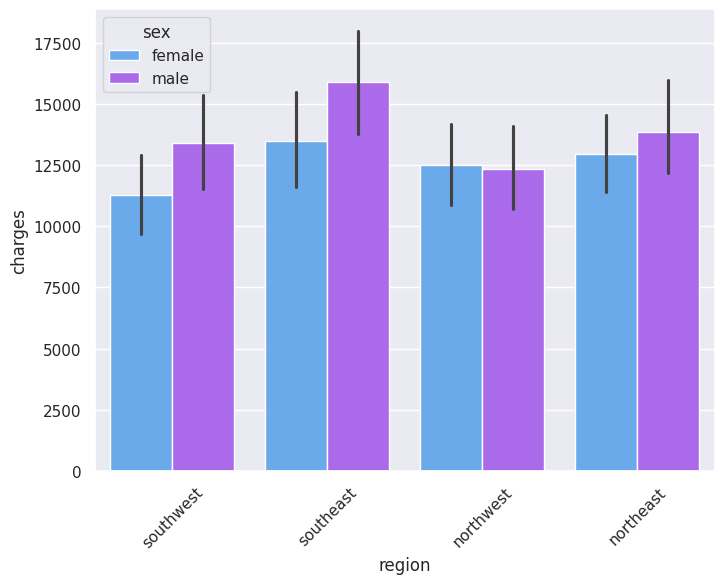

In [359]:
# There are slight difference in charges depending on individual's sex (men's cost are higher)

f, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, ax=ax, palette='cool')
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, 'southwest'),
  Text(1, 0, 'southeast'),
  Text(2, 0, 'northwest'),
  Text(3, 0, 'northeast')])

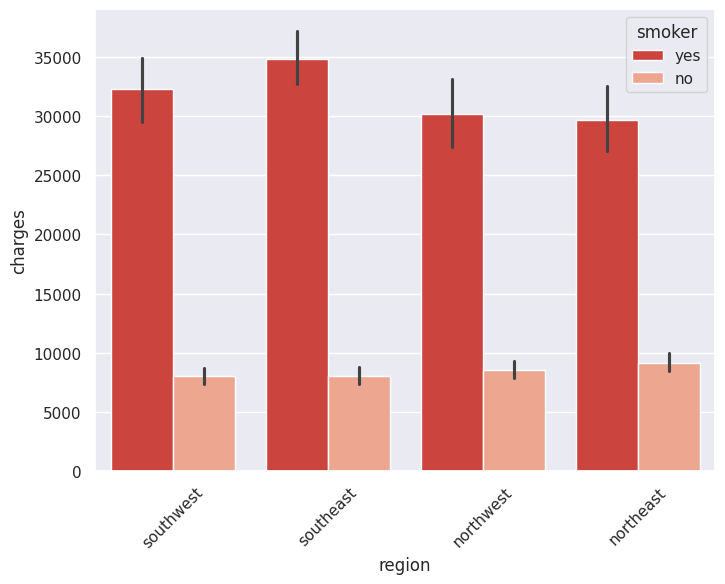

In [360]:
# Smoking habit mainly affects the insurance cost in every regions
# The reason why Southeast region shows the highest insurance cost is because people there smoke more than people in other regions

f, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.barplot(x='region', y='charges', hue='smoker', data=df, ax=ax, palette='Reds_r')
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, 'southwest'),
  Text(1, 0, 'southeast'),
  Text(2, 0, 'northwest'),
  Text(3, 0, 'northeast')])

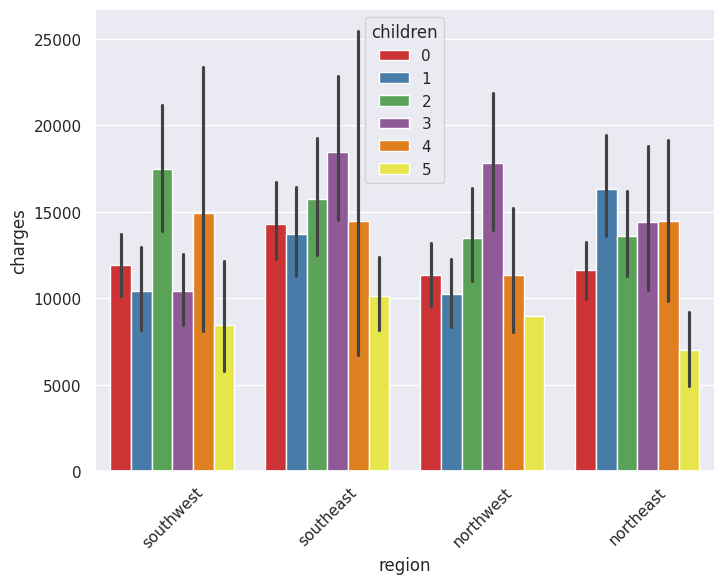

In [361]:
# Dependent number varies in insurance cost per every regions
# Maybe due to the diverse characteristics or medical histroy of family members

f, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, ax=ax, palette='Set1')
plt.xticks(rotation=45)

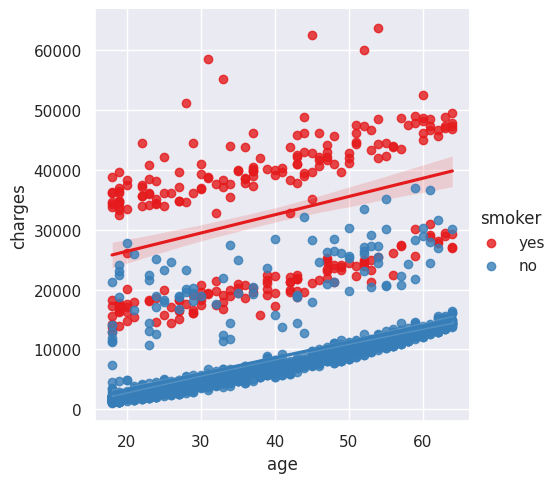

In [362]:
# Smoking habit still is the main contributor to expensive insurance costs while the cost also increases when people gets older

ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')

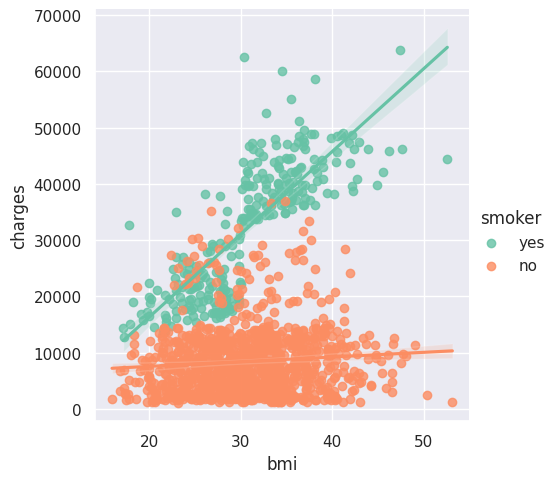

In [363]:
# It looks like BMI does not really affect the insurance cost since non-smoker has stable cost across the BMI range

ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')

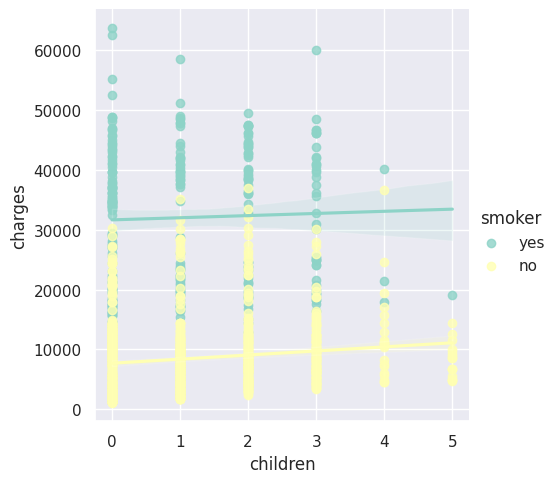

In [364]:
# As we saw from the above plot, number of dependents does not highly affect the cost that much, but the smoking habit

ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

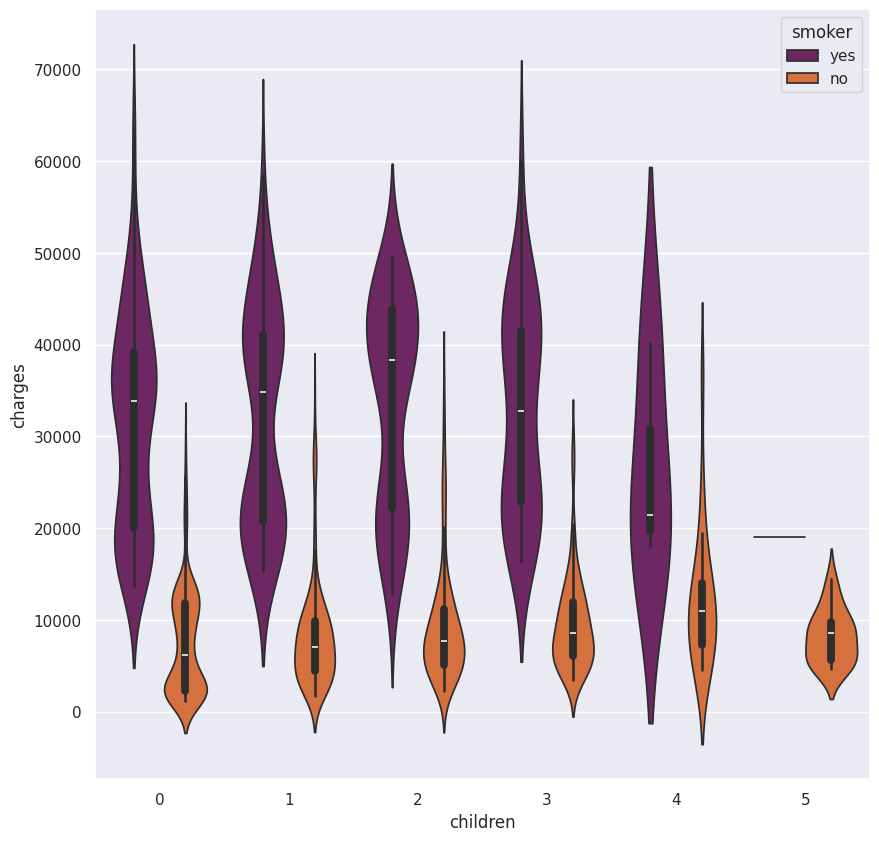

In [365]:
# Also, the interesting part is that people tend to stop smoking when they have more dependents

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df,
                 orient='v', hue='smoker', palette='inferno')

In [366]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


## Encoding Categorical features

In [367]:
all_encoded_df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
all_encoded_df[['sex_male',	'smoker_yes', 'region_northwest',	'region_southeast',	'region_southwest']] = all_encoded_df[['sex_male',	'smoker_yes', 'region_northwest',	'region_southeast',	'region_southwest']].astype(int)

In [368]:
all_encoded_df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


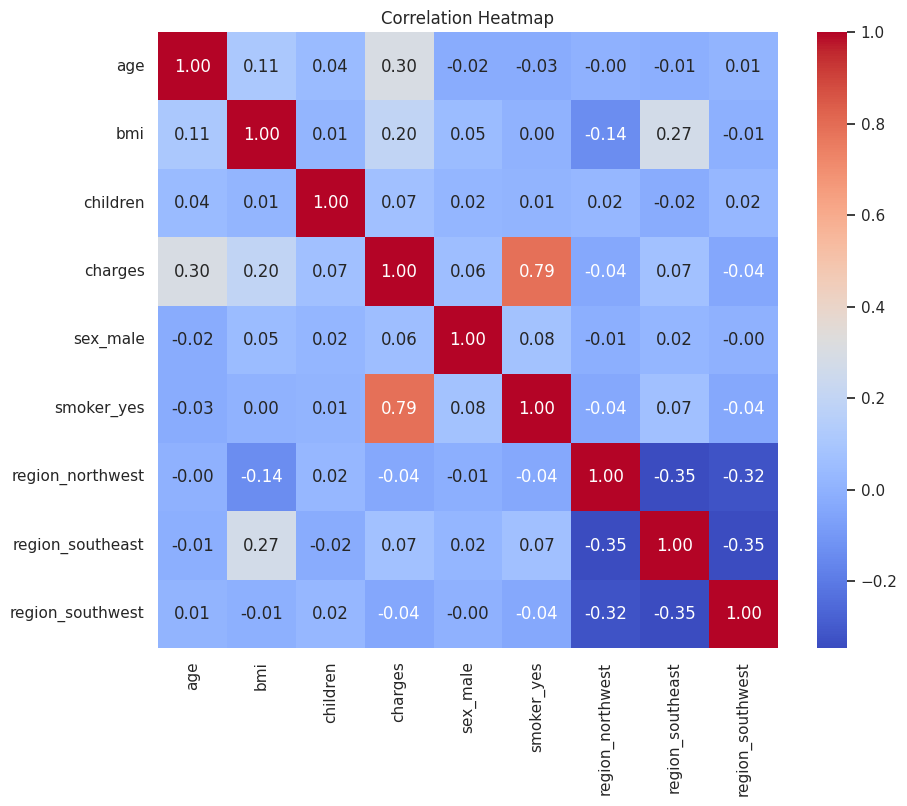

In [369]:
# All the features are not really correlated to each other (If non-target variables are correlated highly to each other, we should drop them)

corr_matrix = all_encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

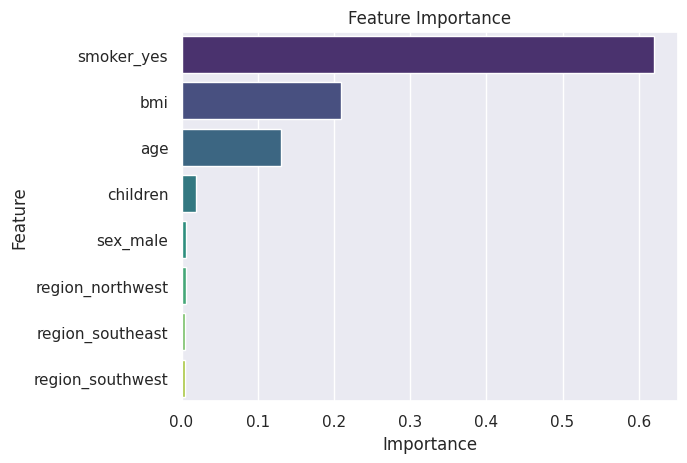

In [370]:
# If we have so many features to use for training the model, we can drop features that are not affecting the target variables
# But, in this case, we have only 8 feature, so I will just keep it
# Smoking habit, bmi, age are the most important features that determines the insurance cost

rf = RandomForestRegressor(random_state=42)
rf.fit(all_encoded_df.drop(columns=['charges']), all_encoded_df['charges'])

feature_importances = pd.DataFrame({'Feature': all_encoded_df.drop(columns=['charges']).columns,
                                    'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance')
plt.show()

## Linear Regression Model

In [371]:
x = all_encoded_df.drop(['charges'], axis=1)
y = all_encoded_df['charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

print("Intercept:", lin_reg.intercept_)
print("Coefficients:", lin_reg.coef_)

Intercept: -11144.822081665181
Coefficients: [  255.70145568   312.7704821    459.33567672    41.71795745
 23889.45100552  -430.23825618  -892.57857189  -792.83305209]


### Metrics that evaluate the Regression model performance

1. R^2: Measures the proportion of variance in the target variable explained by the model; closer to 1 indicates better fit.
2. MSE: Calculates the average squared difference between predicted and actual values; penalizes larger errors more heavily.
3. RMSE: The square root of MSE, representing the average error in the same units as the target variable.
4. MAE: Measures the average of absolute differences between predicted and actual values; less sensitive to outliers.

In [372]:
y_pred = lin_reg.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {lin_reg.score(x_test, y_test):.4f}") # How well features explain the model
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}") # How our predicted cost is different from actual cost
print(f"MAE: {mae:.2f}")

R² Score: 0.7651
MSE: 35406381.31
RMSE: 5950.33
MAE: 4015.97


## Ridge Regression

#### : Regression that includes a penalty term to reduce overfitting by shrinking coefficients. It is also called L2 Regularization

In [373]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.5)
ridge_model.fit(x_train, y_train)

print("Intercept:", ridge_model.intercept_)
print("Coefficients:", ridge_model.coef_)

Intercept: -11131.805570370063
Coefficients: [  255.65680445   312.6713259    459.42693899    45.90292176
 23819.15278404  -428.62071474  -883.60985803  -789.19072654]


In [374]:
# Since, our features are not that related to each other, the result from Ridge (L2) regression is not much different from RLR

y_pred = ridge_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {ridge_model.score(x_test, y_test):.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R² Score: 0.7652
MSE: 35403438.15
RMSE: 5950.08
MAE: 4020.98


## Lasso Regression

#### : Regression that adds an penalty to the loss function, shrinking some coefficients to zero.

In [375]:
lasso_model = Lasso(alpha=0.2, fit_intercept=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
lasso_model.fit(x_train, y_train)

print("Intercept:", lasso_model.intercept_)
print("Coefficients:", lasso_model.coef_)

Intercept: -11145.673234285623
Coefficients: [  255.70475271   312.73744221   459.17936983    40.9725265
 23888.30608741  -427.00530935  -889.1796235   -789.48102736]


In [376]:
# Since, our features are not that related to each other, the result from Lasso (L1) regression is not much different from RLR

y_pred = lasso_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {lasso_model.score(x_test, y_test):.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R² Score: 0.7651
MSE: 35406468.06
RMSE: 5950.33
MAE: 4016.13


## Random Forest Regression

#### : Ensemble method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting.

In [377]:
from sklearn.ensemble import RandomForestRegressor

Rfr = RandomForestRegressor(n_estimators = 100, criterion = 'squared_error',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(x_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=1)

In [378]:
y_pred = Rfr.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {Rfr.score(x_test, y_test):.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R² Score: 0.8521
MSE: 22302602.31
RMSE: 4722.56
MAE: 2722.31


## Polynomial Regression (The Best Performing Model)

#### : Regression where the relationship between the independent variable and dependent variable is modeled as an n-degree polynomial.



In [379]:
all_encoded_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [380]:
from sklearn.preprocessing import PolynomialFeatures

x = all_encoded_df.drop(['charges'], axis = 1)
y = all_encoded_df.charges

pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_pol, y, test_size=0.2, random_state=0)

Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)

print(Pol_reg.intercept_)
print(Pol_reg.coef_)

-3221.320181786674
[ 2.52493711e-08 -5.49004453e+01  4.69527220e+02  1.04339796e+03
 -1.07030646e+03 -9.91215353e+03 -1.44901111e+03  6.03450917e+02
 -1.27660219e+02  3.03590199e+00  1.15572795e+00  1.19009052e-01
  1.88942635e+01  5.17584323e+00  2.21524771e+01  4.27036209e+01
  5.13380340e+01 -7.38454123e+00  1.54533367e+01  1.82462270e+01
  1.44801674e+03  2.35985621e+01 -1.28529691e+02 -9.87273265e+01
 -9.60916028e+01 -3.49209647e+02 -4.73103755e+02  7.65819069e+01
 -4.52101507e+02 -5.82950613e+02 -1.07030646e+03 -6.22726715e+02
  1.49934103e+03  1.45265045e+03  8.50939044e+02 -9.91215353e+03
 -4.18224544e+02 -6.47852300e+02  1.08645069e+03 -1.44901111e+03
  0.00000000e+00  0.00000000e+00  6.03450917e+02  0.00000000e+00
 -1.27660219e+02]


In [381]:
y_pred = Pol_reg.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {Pol_reg.score(x_test, y_test):.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R² Score: 0.8803
MSE: 19053894.84
RMSE: 4365.08
MAE: 2958.67


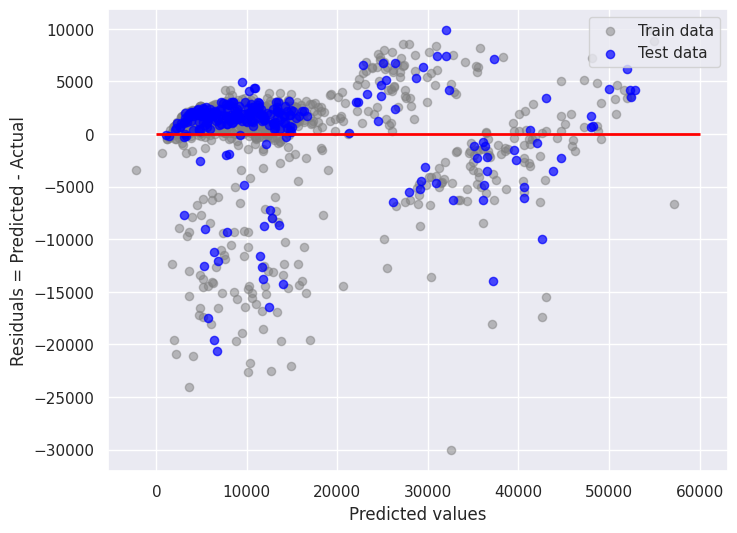

In [382]:
x_train_pred = Pol_reg.predict(x_train)
x_test_pred = Pol_reg.predict(x_test)

plt.figure(figsize=(8,6))

plt.scatter(x_train_pred, x_train_pred - y_train,
          c = 'gray', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(x_test_pred, x_test_pred - y_test,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals = Predicted - Actual')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')

## Data-Based Analysis
: The fact that feature increases don’t always lead to higher charges indicates a complex relationship between features and the target variable.

1. Age: Age may significantly impact charges in certain ranges but have a smaller or negligible effect beyond a specific threshold.
2. BMI: Charges may increase at very low or high BMI values but show minimal impact for moderate BMI levels.
3. Children: The number of children might heavily influence charges up to a point, after which additional children may no longer make a notable difference.